In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import seaborn as sns
import lightgbm as lgb
import json
from pandas.io.json import json_normalize
import datetime
from sklearn import metrics
from sklearn.model_selection import train_test_split,KFold,TimeSeriesSplit
%matplotlib inline



In [84]:
columns=['device','geoNetwork','totals','trafficSource']

filename='Documents/input/train.csv'

train_df=pd.read_csv(filename, 
                    converters={column:json.loads for column in columns},
                    dtype={'fullVisitorId':'str'})
for column in columns:
        column_as_df = json_normalize(train_df[column])
        column_as_df.columns = ["{0}.{1}".format(column,subcolumn) for subcolumn in column_as_df.columns]
        train_df = train_df.drop(column, axis=1).merge(column_as_df, right_index=True, left_index=True)
        
    
    


In [3]:
train_df.head()

,channelGrouping,date,fullVisitorId,sessionId,socialEngagementType,visitId,visitNumber,visitStartTime,device.browser,device.browserSize,...,trafficSource.adwordsClickInfo.isVideoAd,trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.slot,trafficSource.campaign,trafficSource.campaignCode,trafficSource.isTrueDirect,trafficSource.keyword,trafficSource.medium,trafficSource.referralPath,trafficSource.source
0,Organic Search,20160902,1131660440785968503,1131660440785968503_1472830385,Not Socially Engaged,1472830385,1,1472830385,Chrome,not available in demo dataset,...,NaN,NaN,NaN,(not set),NaN,NaN,(not provided),organic,NaN,google
1,Organic Search,20160902,377306020877927890,377306020877927890_1472880147,Not Socially Engaged,1472880147,1,1472880147,Firefox,not available in demo dataset,...,NaN,NaN,NaN,(not set),NaN,NaN,(not provided),organic,NaN,google
2,Organic Search,20160902,3895546263509774583,3895546263509774583_1472865386,Not Socially Engaged,1472865386,1,1472865386,Chrome,not available in demo dataset,...,NaN,NaN,NaN,(not set),NaN,NaN,(not provided),organic,NaN,google
3,Organic Search,20160902,4763447161404445595,4763447161404445595_1472881213,Not Socially Engaged,1472881213,1,1472881213,UC Browser,not available in demo dataset,...,NaN,NaN,NaN,(not set),NaN,NaN,google + online,organic,NaN,google
4,Organic Search,20160902,27294437909732085,27294437909732085_1472822600,Not Socially Engaged,1472822600,2,1472822600,Chrome,not available in demo dataset,...,NaN,NaN,NaN,(not set),NaN,True,(not provided),organic,NaN,google


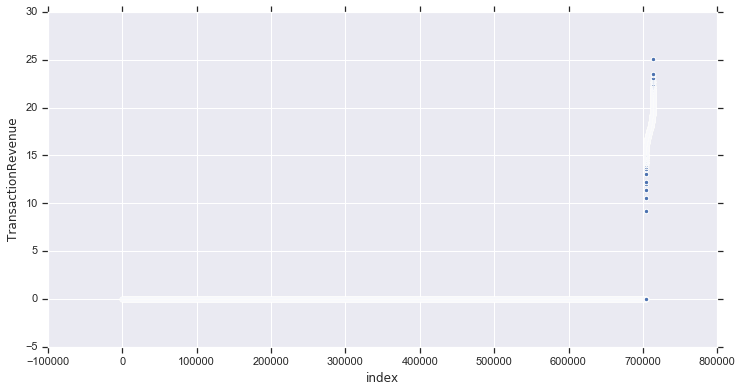

In [95]:
train_df["totals.transactionRevenue"]=train_df["totals.transactionRevenue"].astype('float')
gdf=train_df.groupby("fullVisitorId")["totals.transactionRevenue"].sum().reset_index()

plt.figure(figsize=(12,6)
plt.scatter(range(gdf.shape[0]),np.sort(np.log1p(gdf["totals.transactionRevenue"].values)))
plt.xlabel('index',fontsize=12)
plt.ylabel('TransactionRevenue',fontsize=12)
plt.show()

In [5]:
total=train_df.isnull().sum().sort_values(ascending=False)
percent=total/train_df.shape[0]
Null_df=pd.concat([total,percent],axis=1,keys=['total','percent'])
Null_df.head(n=10)

,total,percent
trafficSource.campaignCode,903652,0.999999
trafficSource.adContent,892707,0.987887
totals.transactionRevenue,892138,0.987257
trafficSource.adwordsClickInfo.page,882193,0.976252
trafficSource.adwordsClickInfo.adNetworkType,882193,0.976252
trafficSource.adwordsClickInfo.slot,882193,0.976252
trafficSource.adwordsClickInfo.isVideoAd,882193,0.976252
trafficSource.adwordsClickInfo.gclId,882092,0.976140
trafficSource.isTrueDirect,629648,0.696781
trafficSource.referralPath,572712,0.633774


In [28]:
from kmodes.kmodes import KModes 

km=KModes(n_clusters=3,init="Cao",n_init=2,verbose=1)
subset_columns=['geoNetwork.continent','totals.pageviews']
subset_df=train_df[subset_columns]
#subset_df['totals.visits'].fillna(1,inplace=True)
subset_df['totals.pageviews'].fillna(1,inplace=True)
#subset_df['totals.visits']=subset_df['totals.visits'].astype(int)
subset_df['totals.pageviews']=subset_df['totals.pageviews'].astype(int)
subset_df.drop_duplicates(inplace=True)
fitClusters=km.fit_predict(subset_df)

print(km.cluster_centroids_)



Initialization method and algorithm are deterministic. Setting n_init to 1.


C:\Anaconda3\lib\site-packages\pandas\core\generic.py:5434: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 0, cost: 733.0
[['Americas' '1']
 ['Asia' '2']
 ['Europe' '3']]


C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


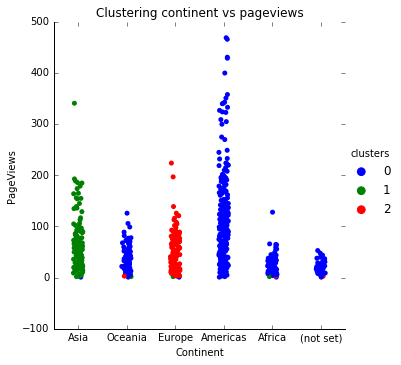

In [32]:
subset_df['clusters']=fitClusters
subset_df=subset_df.drop_duplicates()



svm=sns.catplot('geoNetwork.continent','totals.pageviews',data=subset_df,hue="clusters")
plt.title('Clustering continent vs pageviews')
plt.xlabel('Continent')
plt.ylabel('PageViews')
svm.savefig('clustering.jpg')




In [35]:
from kmodes.kmodes import KModes 

km=KModes(n_clusters=3,init="Cao",n_init=2,verbose=1)
subset_columns=['geoNetwork.continent','totals.hits']
subset_df=train_df[subset_columns]
subset_df['totals.hits'].fillna(1,inplace=True)

subset_df['totals.hits']=subset_df['totals.hits'].astype(int)

subset_df.drop_duplicates(inplace=True)
fitClusters=km.fit_predict(subset_df)

print(km.cluster_centroids_)

Initialization method and algorithm are deterministic. Setting n_init to 1.


C:\Anaconda3\lib\site-packages\pandas\core\generic.py:5434: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 0, cost: 945.0
[['Americas' '1']
 ['Asia' '2']
 ['Europe' '3']]


C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


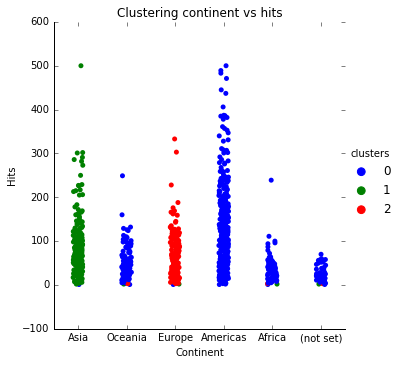

In [36]:
subset_df['clusters']=fitClusters
subset_df=subset_df.drop_duplicates()



svm=sns.catplot('geoNetwork.continent','totals.hits',data=subset_df,hue="clusters")
plt.title('Clustering continent vs hits')
plt.xlabel('Continent')
plt.ylabel('Hits')
svm.savefig('clustering1.jpg')


In [85]:
columns=['device','geoNetwork','totals','trafficSource']

filename='Documents/input/test.csv'
test_df=pd.read_csv(filename, 
                    converters={column:json.loads for column in columns},
                    dtype={'fullVisitorId':'str'})
for column in columns:
        column_as_df = json_normalize(test_df[column])
        column_as_df.columns = ["{0}.{1}".format(column,subcolumn) for subcolumn in column_as_df.columns]
        test_df = test_df.drop(column, axis=1).merge(column_as_df, right_index=True, left_index=True)

In [38]:
test_df.shape

(804684, 53)

In [86]:
no_use=['trafficSource.adContent','trafficSource.adwordsClickInfo.page','trafficSource.adwordsClickInfo.adNetworkType','trafficSource.adwordsClickInfo.slot',
'trafficSource.adwordsClickInfo.gclId']
train_df.drop(no_use,axis=1,inplace=True)
test_df.drop(no_use,axis=1,inplace=True)

train_df['trafficSource.adwordsClickInfo.isVideoAd'].fillna(True, inplace=True)
test_df['trafficSource.adwordsClickInfo.isVideoAd'].fillna(True, inplace=True)
train_df['trafficSource.isTrueDirect'].fillna(False, inplace=True)
test_df['trafficSource.isTrueDirect'].fillna(False, inplace=True)

In [87]:
def date_format(df):
    df['date'] = df['date'].astype(str)
    df["date"] = df["date"].apply(lambda x : x[:4] + "-" + x[4:6] + "-" + x[6:])
    df["date"] = pd.to_datetime(df["date"])
    
    df["month"]   = df['date'].dt.month
    df["day"]     = df['date'].dt.day
    df["weekday"] = df['date'].dt.weekday
    df['weekofyear']=df['date'].dt.weekofyear
    
    df['month_unique_user_count']=df.groupby('month')['fullVisitorId'].transform('nunique')
    
    df['day_unique_user_count']=df.groupby('day')['fullVisitorId'].transform('nunique')
    
    df['weekday_unique_user_count']=df.groupby('weekday')['fullVisitorId'].transform('nunique')
    
    df['weekofyear_unique_user_count']=df.groupby('weekofyear')['fullVisitorId'].transform('nunique')
    
    
    return df 


In [88]:
train_df=date_format(train_df)
test_df=date_format(test_df)


In [89]:
constant_cols = [col for col in train_df.columns if train_df[col].nunique(dropna=False) == 1]
train_df.drop(constant_cols,axis=1,inplace=True)
test_df.drop([col for col in constant_cols if col in test_df.columns],axis=1,inplace=True)
train_df.drop(['trafficSource.campaignCode'],axis=1,inplace=True)

print('Columns dropped:{0}'.format(len(constant_cols)))
constant_cols

Columns dropped:19


['socialEngagementType',
 'device.browserSize',
 'device.browserVersion',
 'device.flashVersion',
 'device.language',
 'device.mobileDeviceBranding',
 'device.mobileDeviceInfo',
 'device.mobileDeviceMarketingName',
 'device.mobileDeviceModel',
 'device.mobileInputSelector',
 'device.operatingSystemVersion',
 'device.screenColors',
 'device.screenResolution',
 'geoNetwork.cityId',
 'geoNetwork.latitude',
 'geoNetwork.longitude',
 'geoNetwork.networkLocation',
 'totals.visits',
 'trafficSource.adwordsClickInfo.criteriaParameters']

In [90]:
def transform_feature(data):
    data['browser_category']=data['device.browser']+'_'+data['device.deviceCategory']
    
    data['browser_operatingSystem']=data['device.browser']+'_'+data['device.operatingSystem']
    
    data['source_country']=data['trafficSource.source']+'_'+data['geoNetwork.country']
    
    return data

train_df=transform_feature(train_df)
test_df=transform_feature(test_df)
    

In [91]:
def _normalize_numerical_cols(df, isTrain = True):
    
    df['visitNumber']=np.log1p(df['visitNumber'].astype(int))
    
    df['totals.hits']=np.log1p(df['totals.hits'].astype(int))
    
    df['totals.pageviews'].fillna(1, inplace=True) #filling NA's with 1
    df['totals.pageviews']=np.log1p(df['totals.pageviews'].astype(int))
    
    df['sum_pageview_per_network']=df.groupby('geoNetwork.networkDomain')['totals.pageviews'].transform('sum')
    
    df['count_pageview_per_network']=df.groupby('geoNetwork.networkDomain')['totals.pageviews'].transform('count')
    
    df['mean_pageview_per_network']=df.groupby('geoNetwork.networkDomain')['totals.pageviews'].transform('mean')
    
    df['sum_hits_per_network']=df.groupby('geoNetwork.networkDomain')['totals.hits'].transform('sum')
    
    df['count_hits_per_network']=df.groupby('geoNetwork.networkDomain')['totals.hits'].transform('count')
    
    df['mean_hits_per_network']=df.groupby('geoNetwork.networkDomain')['totals.hits'].transform('mean')
    
    df['mean_hits_per_day']=df.groupby('date')['totals.hits'].transform('mean')
    
    df['sum_hits_per_day']=df.groupby('date')['totals.hits'].transform('sum')

    df['sum_pageviews_per_region']=df.groupby('geoNetwork.region')['totals.pageviews'].transform('sum')
    
    df['count_pageviews_per_region']=df.groupby('geoNetwork.region')['totals.pageviews'].transform('count')
    
    df['mean_pageviews_per_region']=df.groupby('geoNetwork.region')['totals.pageviews'].transform('mean')
    
    df['sum_hits_per_region']=df.groupby('geoNetwork.region')['totals.hits'].transform('sum')
    
    df['count_hits_per_region']=df.groupby('geoNetwork.region')['totals.hits'].transform('count')
    
    df['mean_hits_per_region']=df.groupby('geoNetwork.region')['totals.hits'].transform('mean')
    
    df['sum_hits_per_country']=df.groupby('geoNetwork.country')['totals.hits'].transform('sum')
    
    df['count_hits_per_country']=df.groupby('geoNetwork.country')['totals.hits'].transform('count')
    
    df['mean_hits_per_country']=df.groupby('geoNetwork.country')['totals.hits'].transform('mean')
    
    df['user_pageviews_sum']=df.groupby('fullVisitorId')['totals.pageviews'].transform('sum')
    
    df['user_hits_sum']=df.groupby('fullVisitorId')['totals.hits'].transform('sum')
    
    df['user_pageviews_count']=df.groupby('fullVisitorId')['totals.pageviews'].transform('count')
    
    df['user_hits_count']=df.groupby('fullVisitorId')['totals.hits'].transform('count')
    
    df['user_pageviews_sum_to_mean']=df['user_pageviews_sum']/df['user_pageviews_sum'].mean()
    
    df['user_hits_sum_to_mean']=df['user_hits_sum']/df['user_hits_sum'].mean()
    
    df['user_pageviews_to_region']=df['user_pageviews_sum']/df['mean_pageviews_per_region']
    
    df['user_hits_to_region']=df['user_hits_sum']/df['mean_hits_per_region']
    
    df['totals.newVisits'].fillna(0, inplace=True) #filling NA's with 0
    df['totals.bounces'].fillna(0, inplace=True)   #filling NA's with 0
    
    df["totals.bounces"]=df["totals.bounces"].astype(int)
    
    df["totals.newVisits"]=df["totals.newVisits"].astype(int)
    
    
    if isTrain:
        df["totals.transactionRevenue"] = df["totals.transactionRevenue"].fillna(0.0)
    return df 

train_df = _normalize_numerical_cols(train_df)
test_df = _normalize_numerical_cols(test_df, isTrain = False)

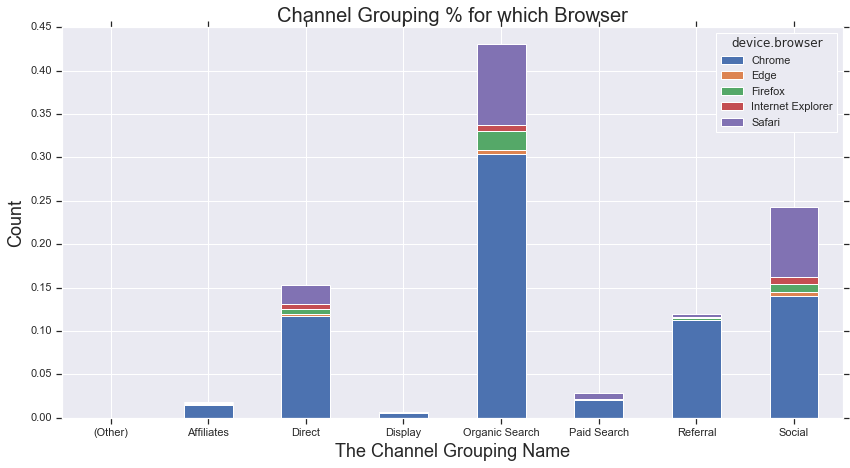

In [121]:
from plotly.offline import init_notebook_mode, iplot
import plotly.graph_objs as go
crosstab_eda = pd.crosstab(index=train_df['channelGrouping'], normalize=True,
                           
                           columns=train_df[train_df['device.browser'].isin(train_df['device.browser']\
                                                                            .value_counts()[:5].index.values)]['device.browser'])

crosstab_eda.plot(kind="bar",figsize=(14,7), 
                 stacked=True)   
plt.title("Channel Grouping % for which Browser", fontsize=20)
plt.xlabel("The Channel Grouping Name", fontsize=18) 
plt.ylabel("Count", fontsize=18)
plt.xticks(rotation=0)
plt.savefig('channel_grouping.jpg')

In [119]:
from plotly import tools
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go


def horizontal_bar_chart(cnt_srs, color):
    trace = go.Bar(
        y=cnt_srs.index[::-1],
        x=cnt_srs.values[::-1],
        showlegend=False,
        orientation = 'h',
        marker=dict(
            color=color,
        ),
    )
    return trace

# Continent
cnt_srs = train_df.groupby('geoNetwork.continent')['totals.transactionRevenue'].agg(['size', 'count', 'mean'])
cnt_srs.columns = ["count", "count of non-zero revenue", "mean"]
cnt_srs = cnt_srs.sort_values(by="count", ascending=False)
trace1 = horizontal_bar_chart(cnt_srs["count"].head(10), 'rgba(58, 71, 80, 0.6)')
trace2 = horizontal_bar_chart(cnt_srs["count of non-zero revenue"].head(10), 'rgba(58, 71, 80, 0.6)')
trace3 = horizontal_bar_chart(cnt_srs["mean"].head(10), 'rgba(58, 71, 80, 0.6)')

# Sub-continent
cnt_srs = train_df.groupby('geoNetwork.subContinent')['totals.transactionRevenue'].agg(['size', 'count', 'mean'])
cnt_srs.columns = ["count", "count of non-zero revenue", "mean"]
cnt_srs = cnt_srs.sort_values(by="count", ascending=False)
trace4 = horizontal_bar_chart(cnt_srs["count"], 'orange')
trace5 = horizontal_bar_chart(cnt_srs["count of non-zero revenue"], 'orange')
trace6 = horizontal_bar_chart(cnt_srs["mean"], 'orange')

# Network domain
cnt_srs = train_df.groupby('geoNetwork.networkDomain')['totals.transactionRevenue'].agg(['size', 'count', 'mean'])
cnt_srs.columns = ["count", "count of non-zero revenue", "mean"]
cnt_srs = cnt_srs.sort_values(by="count", ascending=False)
trace7 = horizontal_bar_chart(cnt_srs["count"].head(10), 'blue')
trace8 = horizontal_bar_chart(cnt_srs["count of non-zero revenue"].head(10), 'blue')
trace9 = horizontal_bar_chart(cnt_srs["mean"].head(10), 'blue')

# Creating two subplots
fig = tools.make_subplots(rows=3, cols=3, vertical_spacing=0.08, horizontal_spacing=0.15, 
                          subplot_titles=["Continent - Count", "Continent - Non-zero Revenue Count", "Continent - Mean Revenue",
                                          "Sub Continent - Count",  "Sub Continent - Non-zero Revenue Count", "Sub Continent - Mean Revenue",
                                          "Network Domain - Count", "Network Domain - Non-zero Revenue Count", "Network Domain - Mean Revenue"])

fig.append_trace(trace1, 1, 1)
fig.append_trace(trace2, 1, 2)
fig.append_trace(trace3, 1, 3)
fig.append_trace(trace4, 2, 1)
fig.append_trace(trace5, 2, 2)
fig.append_trace(trace6, 2, 3)
fig.append_trace(trace7, 3, 1)
fig.append_trace(trace8, 3, 2)
fig.append_trace(trace9, 3, 3)

fig['layout'].update(height=1500, width=1200, paper_bgcolor='rgb(233,233,233)', title="Geography Plots")
py.iplot(fig, filename='geo-plots')


This is the format of your plot grid:
[ (1,1) x1,y1 ]  [ (1,2) x2,y2 ]  [ (1,3) x3,y3 ]
[ (2,1) x4,y4 ]  [ (2,2) x5,y5 ]  [ (2,3) x6,y6 ]
[ (3,1) x7,y7 ]  [ (3,2) x8,y8 ]  [ (3,3) x9,y9 ]



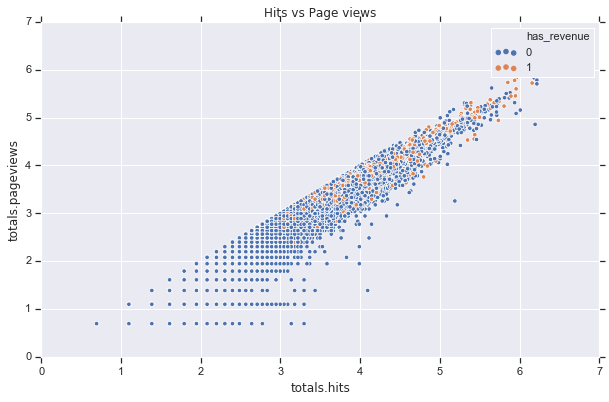

In [111]:
plt.figure(figsize=(10,6))
plt.title("Hits vs Page views")
train_df['has_revenue'] = train_df['totals.transactionRevenue'].apply(lambda x: 1 if x > 0 else 0)
tmp = train_df[['totals.hits', 'totals.pageviews', 'has_revenue']].copy()

ax = sns.scatterplot(x='totals.hits', y='totals.pageviews', hue='has_revenue', data=tmp)
train_df.drop(['has_revenue'],axis=1,inplace=True)

plt.savefig('hit_page.jpg')

In [45]:
## non relevant columns
non_relevant = ["visitNumber", "fullVisitorId", "sessionId", "visitId", "visitStartTime","trafficSource.referralPath"]
from sklearn.preprocessing import LabelEncoder

cat_cols=[col for col in train_df.columns if train_df[col].dtype=='object' and col not in non_relevant+constant_cols]
print(cat_cols)
# label encode the categorical variables and convert the numerical variables to float
for c in cat_cols:

    le = LabelEncoder()
    train_vals = list(train_df[c].values.astype(str))
    test_vals = list(test_df[c].values.astype(str))
    
    le.fit(train_vals + test_vals)
    
    train_df[c] = le.transform(train_vals)
    test_df[c] = le.transform(test_vals)
    


['channelGrouping', 'device.browser', 'device.deviceCategory', 'device.operatingSystem', 'geoNetwork.city', 'geoNetwork.continent', 'geoNetwork.country', 'geoNetwork.metro', 'geoNetwork.networkDomain', 'geoNetwork.region', 'geoNetwork.subContinent', 'trafficSource.campaign', 'trafficSource.keyword', 'trafficSource.medium', 'trafficSource.source', 'browser_category', 'browser_operatingSystem', 'source_country']


In [83]:
from sklearn.linear_model import LinearRegression

buying_df=train_df.copy()
total_Revenue=buying_df['totals.transactionRevenue'].sum()
buying_df['buying_score']=(buying_df['totals.transactionRevenue'])*100.0/total_Revenue


feat=[c for c in buying_df.columns if c not in constant_cols + non_relevant+['date']]
feat.remove("totals.transactionRevenue")
feat.remove("buying_score")

X=buying_df[feat]
y= buying_df['buying_score']


X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.15)
model=LinearRegression()
model.fit(X_train,y_train)

y_pred=model.predict(X_test)

rmse=np.sqrt(mean_squared_error(y_test,y_pred))
print("Root mean squred error(Score Prediction):{}".format(rmse))

pred=model.predict(X)

sub_df = pd.DataFrame({"fullVisitorId":buying_df["fullVisitorId"].values})

sub_df["PredictedScore"] = pred
sub_df = sub_df.groupby("fullVisitorId")["PredictedScore"].sum().reset_index()
sub_df.columns = ["fullVisitorId", "PredictedScore"]
sub_df.sort_values(by='PredictedScore',ascending=False,inplace=True)
sub_df.head(n=20).to_csv("score_pred.csv", index=False)


Root mean squred error(Score Prediction):0.0037923062867970423


In [69]:

# Split the train dataset into development and valid based on time 
dev_df = train_df[train_df['date']<=pd.Timestamp(datetime.date(2017,5,31))]
val_df = train_df[train_df['date']>pd.Timestamp(datetime.date(2017,5,31))]
dev_y = np.log1p(dev_df["totals.transactionRevenue"].values)
val_y = np.log1p(val_df["totals.transactionRevenue"].values)

features=[c for c in train_df.columns if c not in constant_cols + non_relevant+['date']]
features.remove("totals.transactionRevenue")

dev_X=dev_df[features]
val_X=val_df[features]
test_X=test_df[features]

In [70]:
from sklearn.metrics import mean_absolute_error
def run_lgb(train_X, train_y, val_X, val_y, test_X):
    params = {
        "objective" : "regression",
        "metric" : "rmse", 
        "num_leaves" : 35,
        "min_child_samples" : 100,
        "learning_rate" : 0.1,
        "bagging_fraction" : 0.7,
        "feature_fraction" : 0.5,
        "bagging_frequency" : 5,
        "bagging_seed" : 2018,
        "verbosity" : -1
    }
    
    lgtrain = lgb.Dataset(train_X, label=train_y)
    lgval = lgb.Dataset(val_X, label=val_y)
    model1 = lgb.train(params, lgtrain, 1000, valid_sets=[lgval], early_stopping_rounds=100, verbose_eval=100)
    
    pred_test_y = model1.predict(test_X, num_iteration=model1.best_iteration)
    pred_val_y = model1.predict(val_X, num_iteration=model1.best_iteration)
    return pred_test_y, model1, pred_val_y

# Training the model #
pred_test, model1, pred_val = run_lgb(dev_X, dev_y, val_X, val_y, test_X)
true_score=round(np.sqrt(mean_absolute_error(val_y,pred_val),5))
print("True Score:{0}".format(true_score))

Training until validation scores don't improve for 100 rounds.
[100]	valid_0's rmse: 1.73695
[200]	valid_0's rmse: 1.7336
[300]	valid_0's rmse: 1.73296
[400]	valid_0's rmse: 1.73337
Early stopping, best iteration is:
[304]	valid_0's rmse: 1.73261
True Score:0.32388


In [71]:
def perm_test(n_perm,dev_X,val_X,dev_y,val_y,test_X,true_score,feature):
    perm_test=[]
    for i in range(1,n_perm):
        dev_X[feature]=np.random.permutation(dev_X[feature])
        val_X[feature]=np.random.permutation(val_X[feature])
        pred_test, model1, pred_val = run_lgb(dev_X, dev_y, val_X, val_y, test_X)
        score=round(np.sqrt(mean_absolute_error(val_y,pred_val)),5)
        perm_test.append(score)

    permutation_scores=np.array(perm_test)
    pvalue=(np.sum(permutation_scores >=true_score)+1.0)/(n_perm+1)


    plt.hist(permutation_scores, label='Permutation scores',
         edgecolor='black')
    ylim = plt.ylim()
    plt.plot(2 * [true_score], ylim, '--g', linewidth=3,
         label='Classification Score'
         ' (pvalue %s)' % pvalue)

    plt.ylim(ylim)
    plt.legend()
    plt.xlabel('Score')
    plt.title("P-Score for {0}".format(feature))
    plt.savefig('pscore1.jpg')

perm_test(100,dev_X,val_X,dev_y,val_y,test_X,true_score,'totals.hits')
perm_test(100,dev_X,val_X,dev_y,val_y,test_X,true_score,'totals.bounces')

C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Training until validation scores don't improve for 100 rounds.
[100]	valid_0's rmse: 1.75083
[200]	valid_0's rmse: 1.74862
[300]	valid_0's rmse: 1.74648
Early stopping, best iteration is:
[267]	valid_0's rmse: 1.74594
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's rmse: 1.75394
[200]	valid_0's rmse: 1.75093
[300]	valid_0's rmse: 1.74934
[400]	valid_0's rmse: 1.75064
Early stopping, best iteration is:
[333]	valid_0's rmse: 1.74881
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's rmse: 1.75167
[200]	valid_0's rmse: 1.75033
[300]	valid_0's rmse: 1.74936
Early stopping, best iteration is:
[262]	valid_0's rmse: 1.74852
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's rmse: 1.75243
[200]	valid_0's rmse: 1.74905
[300]	valid_0's rmse: 1.74753
Early stopping, best iteration is:
[275]	valid_0's rmse: 1.74696
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's rmse: 1.75298
[200]

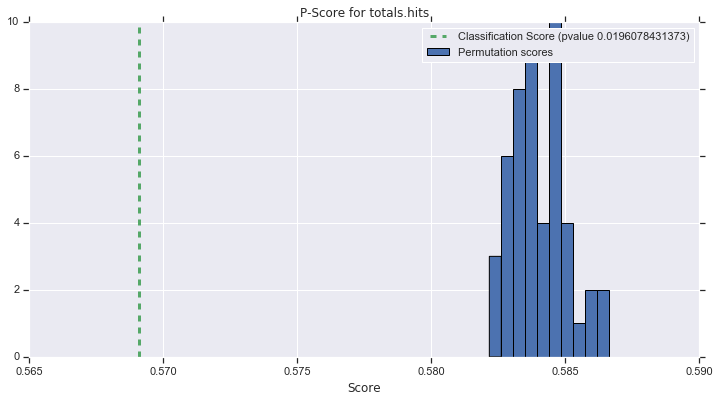

In [122]:

permutation_scores=np.array(perm_test)
pvalue=(np.sum(permutation_scores <=true_score)+1.0)/(n_perm+1)


plt.hist(permutation_scores, label='Permutation scores',
         edgecolor='black')
ylim = plt.ylim()
plt.plot(2 * [true_score], ylim, '--g', linewidth=3,
         label='Classification Score'
         ' (pvalue %s)' % pvalue)

plt.ylim(ylim)
plt.legend()
plt.xlabel('Score')
plt.title("P-Score for totals.hits")
plt.show()
plt.savefig('pscore1.jpg')


In [120]:

n_perm=50
perm_test=[]
for i in range(1,n_perm):
    dev_X['geoNetwork.continent']=np.random.permutation(dev_X['geoNetwork.continent'])
    val_X['geoNetwork.continent']=np.random.permutation(val_X['geoNetwork.continent'])
    pred_test, model1, pred_val = run_lgb(dev_X, dev_y, val_X, val_y, test_X)
    score=round(np.sqrt(mean_absolute_error(val_y,pred_val)),5)
    perm_test.append(score)
    print(i)



C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



Training until validation scores don't improve for 100 rounds.
[100]	valid_0's rmse: 1.74949
[200]	valid_0's rmse: 1.74651
Early stopping, best iteration is:
[190]	valid_0's rmse: 1.74633
1
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's rmse: 1.75508
[200]	valid_0's rmse: 1.75117
[300]	valid_0's rmse: 1.75039
[400]	valid_0's rmse: 1.75102
Early stopping, best iteration is:
[345]	valid_0's rmse: 1.74992
2
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's rmse: 1.75295
[200]	valid_0's rmse: 1.75248
Early stopping, best iteration is:
[131]	valid_0's rmse: 1.75177
3
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's rmse: 1.75057
[200]	valid_0's rmse: 1.74774
[300]	valid_0's rmse: 1.74775
[400]	valid_0's rmse: 1.74698
Early stopping, best iteration is:
[349]	valid_0's rmse: 1.74668
4
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's rmse: 1.75217
[200]	valid_0's rmse: 1.749

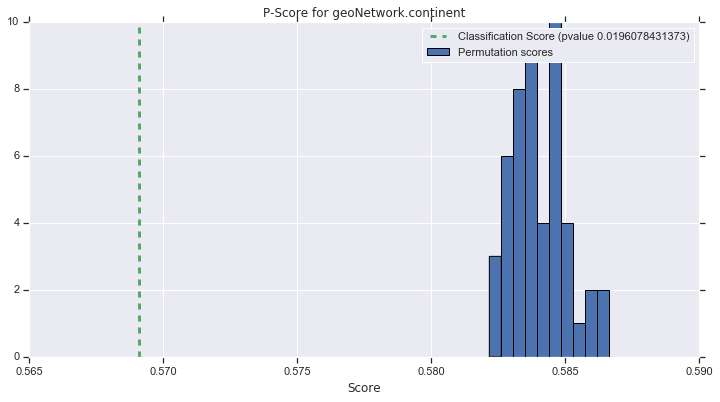

In [125]:

permutation_scores=np.array(perm_test)
pvalue=(np.sum(permutation_scores <=true_score)+1.0)/(n_perm+1)


plt.hist(permutation_scores, label='Permutation scores',
         edgecolor='black')
ylim = plt.ylim()
plt.plot(2 * [true_score], ylim, '--g', linewidth=3,
         label='Classification Score'
         ' (pvalue %s)' % pvalue)

plt.ylim(ylim)
plt.legend()
plt.xlabel('Score')
plt.title("P-Score for geoNetwork.continent")
plt.savefig('pscore2.jpg')


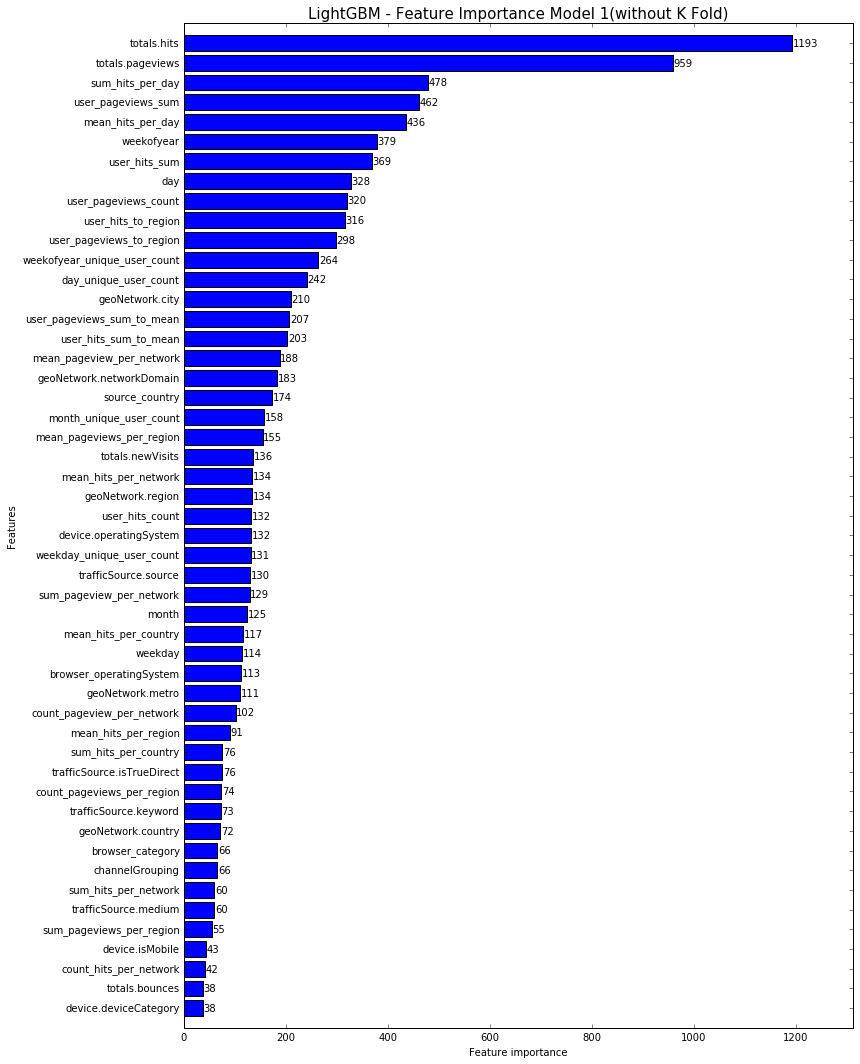

In [48]:
fig, ax = plt.subplots(figsize=(12,18))
lgb.plot_importance(model1, max_num_features=50, height=0.8, ax=ax)
ax.grid(False)
plt.title("LightGBM - Feature Importance Model 1(without K Fold)", fontsize=15)
plt.show()


#pred_val[pred_val<0] = 0
#val_pred_df = pd.DataFrame({"fullVisitorId":val_df["fullVisitorId"].values})
#val_pred_df["transactionRevenue"] = val_df["totals.transactionRevenue"].values
#val_pred_df["PredictedRevenue"] = np.expm1(pred_val)
#val_pred_df = val_pred_df.groupby("fullVisitorId")["transactionRevenue", "PredictedRevenue"].sum().reset_index()
#print(np.sqrt(metrics.mean_squared_error(np.log1p(val_pred_df["transactionRevenue"].values), np.log1p(val_pred_df["PredictedRevenue"].values))))

In [ ]:
sub_df = pd.DataFrame({"fullVisitorId":test_df["fullVisitorId"].values})
pred_test[pred_test<0] = 0
sub_df["PredictedLogRevenue"] = np.expm1(pred_test)
sub_df = sub_df.groupby("fullVisitorId")["PredictedLogRevenue"].sum().reset_index()
sub_df.columns = ["fullVisitorId", "PredictedLogRevenue"]
sub_df["PredictedLogRevenue"] = np.log1p(sub_df["PredictedLogRevenue"])
sub_df.to_csv("final_model1.csv", index=False)

In [ ]:

train_df["totals.transactionRevenue"]=np.log1p(train_df["totals.transactionRevenue"].astype(float))


X=train_df[features]
y=train_df['totals.transactionRevenue']

X_test=test_df[features]



In [ ]:

params={"objective":"regression","metric":"rmse","max_depth":15,"min_child_samples":20, "reg_alpha": 0.2, "reg_lambda": 0.2,
        "num_leaves" : 50, "learning_rate" : 0.01, "subsample" : 0.9, "colsample_bytree" : 0.9, "subsample_freq ": 5}

n_fold=3
folds=KFold(n_splits=n_fold,shuffle=False,random_state=33)

model2=lgb.LGBMRegressor(**params,n_estimators=200)

In [ ]:
prediction=np.zeros(test_df.shape[0])
for fold_n,(train_index,test_index) in enumerate(folds.split(X)):
    print("Fold:",fold_n)
    
    X_train, X_valid = X.iloc[train_index], X.iloc[test_index]
    y_train, y_valid = y.iloc[train_index], y.iloc[test_index]
    

    model2.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_valid, y_valid)], eval_metric='rmse',
            verbose=True, early_stopping_rounds=100)
    
    y_pred = model2.predict(X_test, num_iteration=model2.best_iteration_)
    prediction += y_pred
prediction /= n_fold

In [ ]:
fig, ax = plt.subplots(figsize=(12,18))
lgb.plot_importance(model2, max_num_features=50, height=0.8, ax=ax)
ax.grid(False)
plt.title("LightGBM - Feature Importance Model 2(With KFold)", fontsize=15)
plt.show()


In [ ]:
submission = test_df[['fullVisitorId']].copy()

submission.loc[:, 'PredictedLogRevenue'] = np.expm1(prediction)
submission["PredictedLogRevenue"] = submission["PredictedLogRevenue"].apply(lambda x : 0.0 if x < 0 else x)
submission["PredictedLogRevenue"] = submission["PredictedLogRevenue"].fillna(0.0)
grouped_test = submission[['fullVisitorId', 'PredictedLogRevenue']].groupby('fullVisitorId').sum().reset_index()

grouped_test['PredictedLogRevenue']=np.log1p(grouped_test['PredictedLogRevenue'])

grouped_test.to_csv('model2.csv',index=False)